In [1]:
import torch
from torch import nn
from torchvision import transforms # Preprocess jpg images
from PIL import Image
# import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
import torchvision # Pre-trained CNN

In [3]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda:2'

### Preprocess Flickr8K: Parse captions to lists of ANPs

In [1]:
import spacy
nlp = spacy.load("en_core_web_sm")
def get_ANP(caption, add_empty_adj=False):
    '''Parses a text and returns a list of adj-noun pairs'''
    doc = nlp(caption)
    ANPs = []
    for i,token in enumerate(doc):
        
        # Look for a noun
        if token.pos_ not in ('NOUN'):
            continue

        noun = token.lemma_.lower() # Noun in lemma form
        try:
            # Look for preceding adj
            if doc[i-1].pos_ == 'ADJ':
                adj = doc[i-1].lemma_.lower() # Adj in lemma form
                ANPs.append((adj, noun))
            else:
                if add_empty_adj:
                    ANPs.append(('-', noun))
        except IndexError:
            pass
    return ANPs

get_ANP(u'Three black dogs and a tri-colored dog playing with each other on the road.', add_empty_adj=True)

2022-01-29 17:23:12.462183: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


[('black', 'dog'), ('colored', 'dog'), ('-', 'road')]

In [4]:
from tqdm import tqdm
import pickle

def get_imgs_with_ANPs(fn_caption_file, min_freq=50, keep_empty_adj=False,
                       pickle_fn="saved_fn_anp_dict.pkl"):
    '''Iterate through the img_fn,caption and return img_fn:[(adj,noun)...] '''
    
    # Read previously saved pickle file) => get fn:[ANP...]
    try:
        with open(pickle_fn, "rb") as f:
            print("Reading previously saved dictionary of Filename:Adj-Noun-Pairs...")
            fn_ANP_dict = pickle.load(f)
            
    except FileNotFoundError:
        # Read the txt file => get fn:[ANP...]
        print("Reading captions and looking for Adj-Noun Pairs...")
        with open(fn_caption_file) as f:
            fn_ANP_dict = {}
            lines = [l for l in f]
            for line in tqdm(lines):
                if len(line.split(','))!=2:
                    continue
                fn, cap = line.strip('\n').split(',')
                if fn=='image':
                    continue
                ANPs = get_ANP(cap, add_empty_adj=True)
                if ANPs == []:
                    continue
                # add new key, or expend the ANP list    
                if fn not in fn_ANP_dict:
                    fn_ANP_dict[fn] = ANPs
                else:
                    current_ANPs = fn_ANP_dict[fn]
                    new_ANPs = [x for x in ANPs if x not in current_ANPs]
                    fn_ANP_dict[fn].extend(new_ANPs)
                
        # Save the parsed fn-ANPs dict for future use   
        with open(pickle_fn, "wb") as f:
            pickle.dump(fn_ANP_dict, f)
    
    #===================================================
    #Count the frequency of adjs and nouns
    def count_adj_noun(fn_ANP_dict):
        a_counts, n_counts = {}, {}

        for anp_list in fn_ANP_dict.values():
            for (a,n) in anp_list:
                a_counts[a] = a_counts.get(a,0)+1
                n_counts[n] = n_counts.get(n,0)+1
        return a_counts, n_counts
    
    a_counts, n_counts = count_adj_noun(fn_ANP_dict)  
    if not keep_empty_adj and '-' in a_counts:
        a_counts.pop('-')
    print(f"Before filtering: {len(fn_ANP_dict)} images with ANPs.")
    print(f"{len(a_counts)} adjs, {len(n_counts)} nouns.")
    
    #===================================================
    #Filter adjs and nouns that have appeared minimum N times
    def get_frequent_words(word_count_dict):
        return [w for w,freq in word_count_dict.items() if freq>=min_freq]
    
    print(f"\nAfter filtering: Only keep the adjs or nouns that are annotated in at least {min_freq} images:")
    frequent_adjs = get_frequent_words(a_counts)
    frequent_nouns = get_frequent_words(n_counts)
    ANP_combos = [(a,n) for a in frequent_adjs for n in frequent_nouns]
    print(f"{len(frequent_adjs)} freq adjs X {len(frequent_nouns)} freq nouns = {len(ANP_combos)} possible combinations")
    
    #===================================================
    #Filter images that contain the frequent adjs/nouns
    filtered_fn_ANPs = {}
    for fn, ANPs in fn_ANP_dict.items():
        frequent_ANPs = [(a,n) for a,n in ANPs if a in frequent_adjs and n in frequent_nouns]
        if frequent_ANPs:
            filtered_fn_ANPs[fn]=frequent_ANPs
            
    ANP_set=set()
    for anps in list(filtered_fn_ANPs.values()):
        ANP_set.update(anps)
        
    print(f"{len(filtered_fn_ANPs)} images with {len(ANP_set)} ANPs containing frequent adjs and nouns.")
    
    return frequent_adjs, frequent_nouns, ANP_combos, filtered_fn_ANPs


In [5]:
flickr8k_path = '/scratch/lt2318-h21-resources/03-image-captioning/data/flickr8k/'
flickr8K_caps = flickr8k_path + 'captions.txt'
flickr8K_imgs = flickr8k_path + 'Images/'

adj_classes, noun_classes, ANP_classes, fn_ANPs = get_imgs_with_ANPs(flickr8K_caps, min_freq=150)

Reading previously saved dictionary of Filename:Adj-Noun-Pairs...
Before filtering: 8091 images with ANPs.
1061 adjs, 3915 nouns.

After filtering: Only keep the adjs or nouns that are annotated in at least 150 images:
26 freq adjs X 101 freq nouns = 2626 possible combinations
6057 images with 704 ANPs containing frequent adjs and nouns.


#### Helper functions to turn raw data into PyTorch tensors

In [6]:
def file_to_tensor(img_path):
    # (PIL.Image obj) => pt tensor 3x224x224
    # load jpg directly as tensor of CxHxW to avoid needing converting from numpy and permuting

    preprocess_fn = transforms.Compose([
        transforms.Resize( 240 ), # img gets cropped if it isn't squared-shaped
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])
    
    # PIL Img obj
    with Image.open(img_path) as img:
        img_tensor = preprocess_fn(img)
        return img_tensor

def augment_img_tensors(batch_tensors):
#     tensor_to_PIL = transforms.ToPILImage()
    augment_fn = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0),
                    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2),
                                            shear=None, interpolation=transforms.InterpolationMode.NEAREST,
                                            fill=(255, 255, 255)),
                    transforms.ToTensor(),
                    ])
    # tensors->PIL objs-> randomly change angles, flip, etc ->new tensors
    new_tensors = [augment_fn(x) for x in batch_tensors]
    new_tensors = torch.stack(new_tensors)
    return new_tensors

def multilabels_to_tensor(list_labels, list_classes):
    '''Returns a tensor of length = num_classes, which is filled with 0 or 1'''
    zeros = torch.zeros(len(list_classes))
    for label in list_labels:
        if label in list_classes:
            idx = list_classes.index(label)
            zeros[idx] = 1
    return zeros

def convert_fn_anp_to_xy(fn_anp, img_path=flickr8K_imgs):
    '''Converst a list of (filename, [labels...]) to 
    a list of (img_tensor, multilabels_tensor) tuples'''
    xy=[] 
    for fn, anp_list in tqdm(fn_anp):
        img = file_to_tensor(img_path+fn)
        anp_labels = multilabels_to_tensor(anp_list, ANP_classes)
        
        adjs, nouns = zip(*anp_list)
        adj_labels = multilabels_to_tensor(adjs, adj_classes)
        noun_labels = multilabels_to_tensor(nouns, noun_classes)
        xy.append((img, anp_labels, adj_labels, noun_labels))
    return xy

#### Train and val datasets: (img: tensor, ANP_labels: tensor, adj_labels: tensor, noun_labels: tensor)

In [25]:
def train_val_split(dataset, val_portion=0.2):
    random.shuffle(dataset)
    val_split = int( len(dataset) * val_portion)
    train, val = dataset[val_split:], dataset[:val_split]
    print(f"Total no of data: {len(dataset)}. Split to train:val = {len(train)}:{len(val)}.")
    return train, val

data = list(fn_ANPs.items())
train_fn_anp, val_fn_anp = train_val_split(data)



Total no of data: 6057. Split to train:val = 4846:1211.


In [8]:
trainXY = convert_fn_anp_to_xy(train_fn_anp)
valXY = convert_fn_anp_to_xy(val_fn_anp)

# with open("trainXY.pkl", "wb") as trainf, open("valXY.pkl", "wb") as valf:
#     pickle.dump(trainXY, trainf)
#     pickle.dump(valXY, valf)

100%|██████████████████████████████████████████████████████████████████████████████| 1211/1211 [00:10<00:00, 118.25it/s]


In [8]:
with open("trainXY.pkl", "rb") as trainf, open("valXY.pkl", "rb") as valf:
    print("Load previously saved train and val data...")
    trainXY = pickle.load(trainf)
    valXY = pickle.load(valf)

Load previously saved train and val data...


### Model that outputs multiple labels:
### ResNet -> fc(num_classes) -> Sigmoid

In [7]:
class ResnetTagger(nn.Module):

    def __init__(self, n_classes):
        super().__init__()

        resnet = torchvision.models.resnet101(pretrained=True) # Pretrained ResNet101 model
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.33),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )

        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        out = self.base_model(x)
        return self.sigm(out)
    

In [8]:
class CrossTagger(nn.Module):

    def __init__(self, n_adjs, n_nouns, hiddensize=1024, consider_anp_targets=False, fractorise_from="reps"):
        super().__init__()
        
        resnet = torchvision.models.resnet101(pretrained=True) # Pretrained ResNet101 model
        
        # This layer is shared for both adj&noun
        resnet.fc = nn.Sequential(
            nn.Linear(in_features=resnet.fc.in_features, out_features=hiddensize), 
        )
        self.base_model = resnet
        
        # Separate FCs for adj/noun
        self.adj_fc = nn.Sequential(
            nn.Dropout(p=0.33),
            nn.Linear(in_features=hiddensize, out_features=n_adjs),
        )
        
        self.noun_fc = nn.Sequential(
            nn.Dropout(p=0.33),
            nn.Linear(in_features=hiddensize, out_features=n_nouns),
        )
        
        self.cross_fc = nn.Sequential(
            nn.Linear(in_features=n_adjs*n_nouns, out_features=hiddensize),
        )

        self.out_fc = nn.Sequential(
#             nn.Dropout(p=0.2),
            nn.Linear(in_features=hiddensize, out_features=n_adjs*n_nouns),
        )
        
        self.sigm = nn.Sigmoid()
        self.consider_anp_targets = consider_anp_targets
        self.fractorise_from = fractorise_from


    def forward(self, x):
        resnet_out = self.base_model(x) # ---->to be added to the cross-mul 
        # Train to predict adj/noun separately
        adj_reps, noun_reps = self.adj_fc(resnet_out), self.noun_fc(resnet_out)
        adj_out, noun_out = self.sigm(adj_reps), self.sigm(noun_reps)
        
        if self.consider_anp_targets:
            # Multiply the adj/noun reps|sigmoids and go thru another fc layer

            if self.fractorise_from=="sigmoids": # cf. "semantic-ANP"
                cross_reps = self.cross_multiply(adj_out, noun_out) # AxN Sigmoids matrix of size= B, num_adjs*num_nouns 
            if self.fractorise_from=="reps": # cf. "visual-ANP"
                cross_reps = self.cross_multiply(adj_reps, noun_reps) # AxN reps matrix of size= B, num_adjs*num_nouns 

            cross_reps = self.cross_fc(cross_reps) # BxA*N -> BxHidden
            cross_out = self.out_fc( resnet_out+cross_reps ) # BxHidden + BxHidden: ResNet rep + Cross reps
            cross_out = self.sigm(cross_out) 
        else:
            # Simply multiply the adj/noun sigmoids
            cross_out = self.cross_multiply(adj_out, noun_out)
        
        return cross_out, (adj_out, noun_out)
    
    def cross_multiply(self, t1,t2):
        '''
        Given two tensors of size BxN and BxM, return a tensor of size Bx(N*M),
        where each element in dim1 is i*j for i in N and for j in M
        '''
        # Each element in out-tensor is cross-multiplication of N and M
        out = torch.einsum("di,dj->dij", (t1,t2))
        # Flatten all but the batch dim
        return torch.flatten(out, start_dim=1)

### Train-loop function

In [11]:
from torch.utils.data import DataLoader
from datetime import datetime
from adabound import adabound # installed with `pip3 install adabound`

def chart_losses(epochs, epoch_train_val_losses):
    # ===Draw the line chart===================================
    the_epochs = list(range(1,epochs+1)) # X-axis
    train_losses, val_losses = zip(*epoch_train_val_losses)

    # Lines
    plt.plot(the_epochs, train_losses, label='train loss')
    plt.plot(the_epochs, val_losses, label='val loss')


    plt.title('Losses over iterations')
    plt.xlabel('epoch')
    plt.ylabel('train/val loss')
    plt.legend()
    plt.show()
    
#=============================================================
def train(model, model_name, trainXY, valXY, label_idx,
          device=device, augment_imgs=True,
          batch_size=48, epochs = 10, learning_rate = 1e-4):
    
    model=model.to(device)

    # Grad descend / Loss fn / Dataset iterators
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#     optimizer = adabound.AdaBound(model.parameters(), lr=learning_rate, final_lr=0.1)
#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) # LR adjustment
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    criterion = nn.BCELoss()

    train_loader = DataLoader(trainXY, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valXY, batch_size=batch_size, shuffle=False)

    # Epoch (Train+Val) loop

    # Record time lapses and stats in each epoch 
    train_start_time = datetime.now()
    epoch_train_val_losses = []

    for e in range(1,epochs+1):
        start_time = datetime.now()

        #===TRAIN==============================================
        model.train()
        train_loss = 0
        for i, xy in enumerate(train_loader):
            imgs = xy[0]
            if augment_imgs:
                imgs = augment_img_tensors(imgs) #Random augment train imgs
                
            targets = xy[label_idx] # 1,2,3 for anp, adj, noun
            imgs, targets = imgs.to(device), targets.to(device)

            output = model(imgs)

            loss = criterion(output, targets)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f"Epoch {e} avg train loss {train_loss/(i+1)}", end='\r')
        print()
#         scheduler.step() # Adject LR after an epoch
        
        #===Save model============================================
        torch.save(model, f"trained-models/{model_name}.pt")

        #===VAL/TEST==============================================
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for i, xy in enumerate(val_loader):
                imgs = xy[0] # No augment
                targets = xy[label_idx]
                imgs, targets = imgs.to(device), targets.to(device)
                output = model(imgs)

                loss = criterion(output, targets)
                val_loss += loss.item()
                print(f"Epoch {e} avg val loss   {val_loss/(i+1)}", end='\r')
        print()

        #===EPOCH INFO and STATS=======================================
        lapsed_time = datetime.now()-start_time
        total_lapsed_time = datetime.now()-train_start_time
        print(f"Epoch {e} train+val time:",str(lapsed_time).split('.')[0], 
              "Total lapsed time:", str(total_lapsed_time).split('.')[0],
             )
        epoch_train_val_losses.append((train_loss, val_loss))

    #Finish all epochs    
    print('DONE!')
    chart_losses(epochs, epoch_train_val_losses)
    
    return model


In [12]:
def train_crossmodel(model, model_name, trainXY, valXY,
          device=device, consider_anp_targets=False, augment_imgs=True, 
          batch_size=40, epochs = 10, learning_rate = 1e-4):
    
    model.consider_anp_targets = consider_anp_targets
    if consider_anp_targets and model.consider_anp_targets:
        print('Consider ANP gold labels when training.')
    
    model=model.to(device)

    # Grad descend / Loss fn / Dataset iterators
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#     optimizer = adabound.AdaBound(model.parameters(), lr=learning_rate, final_lr=learning_rate)
#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) # LR adjustment
    criterion = nn.BCELoss()

    train_loader = DataLoader(trainXY, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valXY, batch_size=batch_size, shuffle=False)

    # Epoch (Train+Val) loop

    # Record time lapses and stats in each epoch 
    train_start_time = datetime.now()
    epoch_train_val_losses = []

    for e in range(1,epochs+1):
        start_time = datetime.now()

        #===TRAIN==============================================
        model.train()
        train_loss = 0
        for i, xy in enumerate(train_loader):
            imgs = xy[0]
            if augment_imgs:
                imgs = augment_img_tensors(imgs) #Random augment train imgs
            adj_targets, noun_targets = xy[2], xy[3] # 1,2,3 for anp, adj, noun
            
            imgs, adj_targets, noun_targets = imgs.to(device), adj_targets.to(device), noun_targets.to(device)

            cross_out, (adj_out, noun_out) = model(imgs)
            
            # The loss is based on learning adjs/nouns separately
            if consider_anp_targets:
                anp_targets = xy[1].to(device)
                loss = criterion(cross_out, anp_targets) + criterion(adj_out, adj_targets) + criterion(noun_out, noun_targets)
            else:
                loss = criterion(adj_out, adj_targets) + criterion(noun_out, noun_targets)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f"Epoch {e} avg train loss {train_loss/(i+1)}", end='\r')
        print()
#         scheduler.step() # Adject LR after an epoch
        
        #===Save model============================================
        torch.save(model, f"trained-models/{model_name}.pt")

        #===VAL/TEST==============================================
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for i, xy in enumerate(val_loader):
                imgs = xy[0] # No augment
                adj_targets, noun_targets = xy[2], xy[3] # 1,2,3 for anp, adj, noun
                imgs, adj_targets, noun_targets = imgs.to(device), adj_targets.to(device), noun_targets.to(device)
                cross_out, (adj_out, noun_out) = model(imgs)

                if consider_anp_targets:
                    anp_targets = xy[1].to(device)
                    loss = criterion(cross_out, anp_targets) + criterion(adj_out, adj_targets) + criterion(noun_out, noun_targets)
                else:
                    loss = criterion(adj_out, adj_targets) + criterion(noun_out, noun_targets)
                val_loss += loss.item()
                print(f"Epoch {e} avg val loss   {val_loss/(i+1)}", end='\r')
        print()

        #===EPOCH INFO and STATS=======================================
        lapsed_time = datetime.now()-start_time
        total_lapsed_time = datetime.now()-train_start_time
        print(f"Epoch {e} train+val time:",str(lapsed_time).split('.')[0], 
              "Total lapsed time:", str(total_lapsed_time).split('.')[0],
             )
        epoch_train_val_losses.append((train_loss, val_loss))

    #Finish all epochs    
    print('DONE!')
    chart_losses(epochs, epoch_train_val_losses)
    
    return model

### Initialise new models and train **(Skip this part if already saved trained models)**

/home/gusliahs@GU.GU.SE/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 avg train loss 0.09493859530435783
Epoch 1 avg val loss   0.0071362221183685165
Epoch 1 train+val time: 0:00:55 Total lapsed time: 0:00:55
Epoch 2 avg train loss 0.0063248619640080056
Epoch 2 avg val loss   0.0052705300219643576
Epoch 2 train+val time: 0:00:57 Total lapsed time: 0:01:52
Epoch 3 avg train loss 0.0050936220859241964
Epoch 3 avg val loss   0.0046475105202541925
Epoch 3 train+val time: 0:01:01 Total lapsed time: 0:02:53
Epoch 4 avg train loss 0.0045902848677101115
Epoch 4 avg val loss   0.0043079918339991824
Epoch 4 train+val time: 0:01:02 Total lapsed time: 0:03:55
Epoch 5 avg train loss 0.0043063430797935715
Epoch 5 avg val loss   0.0041350644941513355
Epoch 5 train+val time: 0:01:01 Total lapsed time: 0:04:57
Epoch 6 avg train loss 0.0041309667931002856
Epoch 6 avg val loss   0.0040254717907653404
Epoch 6 train+val time: 0:01:01 Total lapsed time: 0:05:58
Epoch 7 avg train loss 0.0039980557406007655
Epoch 7 avg val loss   0.0039193849168861145
Epoch 7 train+val 

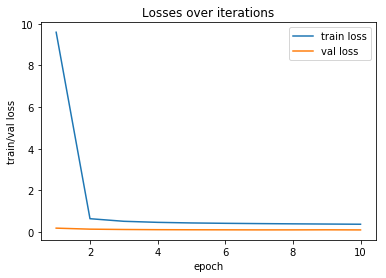

In [16]:
anp_tagger = ResnetTagger(len(ANP_classes))
anp_tagger = train(anp_tagger, "anp-tagger", trainXY, valXY, label_idx=1, augment_imgs=False)

Epoch 1 avg train loss 0.24306269019547075
Epoch 1 avg val loss   0.18736429970998034
Epoch 1 train+val time: 0:00:59 Total lapsed time: 0:00:59
Epoch 2 avg train loss 0.15753770066369888
Epoch 2 avg val loss   0.18329820266136757
Epoch 2 train+val time: 0:00:57 Total lapsed time: 0:01:57
Epoch 3 avg train loss 0.11616580276796133
Epoch 3 avg val loss   0.19786602029433617
Epoch 3 train+val time: 0:00:54 Total lapsed time: 0:02:52
Epoch 4 avg train loss 0.08018561235011214
Epoch 4 avg val loss   0.20842169798337495
Epoch 4 train+val time: 0:00:54 Total lapsed time: 0:03:46
Epoch 5 avg train loss 0.054494206194240266
Epoch 5 avg val loss   0.20889596984936643
Epoch 5 train+val time: 0:00:54 Total lapsed time: 0:04:41
Epoch 6 avg train loss 0.036265889588411496
Epoch 6 avg val loss   0.21282066863316756
Epoch 6 train+val time: 0:00:54 Total lapsed time: 0:05:35
Epoch 7 avg train loss 0.025328918470825897
Epoch 7 avg val loss   0.21951937045042337
Epoch 7 train+val time: 0:00:54 Total lap

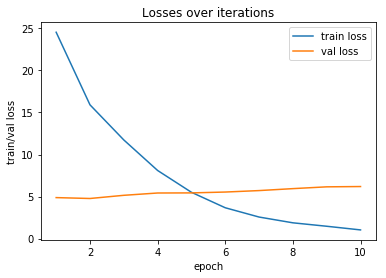

In [17]:
#Train adj multi-label classifier
# Factors affecting losses: (o) fewer classes (x) adj are abstract concepts; ResNet was trained to classify objects (noun-type) 
adj_tagger = ResnetTagger(n_classes=len(adj_classes))
adj_tagger = train(adj_tagger, 'adj-tagger', trainXY=trainXY, valXY=valXY, label_idx=2, augment_imgs=False)

Epoch 1 avg train loss 0.13620293096150501
Epoch 1 avg val loss   0.054596625841580905
Epoch 1 train+val time: 0:01:00 Total lapsed time: 0:01:00
Epoch 2 avg train loss 0.051042572622842126
Epoch 2 avg val loss   0.050419094184270274
Epoch 2 train+val time: 0:01:01 Total lapsed time: 0:02:01
Epoch 3 avg train loss 0.043296615085979584
Epoch 3 avg val loss   0.049415382771537855
Epoch 3 train+val time: 0:01:03 Total lapsed time: 0:03:05
Epoch 4 avg train loss 0.036618029975359984
Epoch 4 avg val loss   0.052302242328341195
Epoch 4 train+val time: 0:01:01 Total lapsed time: 0:04:06
Epoch 5 avg train loss 0.030538403622732305
Epoch 5 avg val loss   0.051547429596002295
Epoch 5 train+val time: 0:01:04 Total lapsed time: 0:05:10
Epoch 6 avg train loss 0.024845562764618655
Epoch 6 avg val loss   0.052635497485215856
Epoch 6 train+val time: 0:00:59 Total lapsed time: 0:06:09
Epoch 7 avg train loss 0.020489926449954513
Epoch 7 avg val loss   0.053009752327433594
Epoch 7 train+val time: 0:01:00

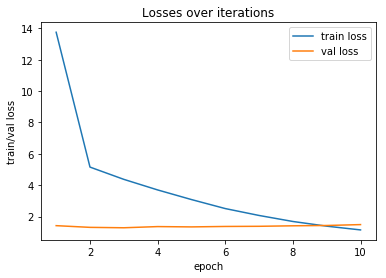

In [18]:
#Train noun multi-label classifier
# Factors affecting losses: (o) ResNet was trained to classify objects (noun-type) 
#                           (x) more classes (but ResNet can classify 1000 classes so should be ok); classes that are too similar, eg, child, girl, boy, kid...
noun_tagger = ResnetTagger(n_classes=len(noun_classes))
noun_tagger = train(noun_tagger, 'noun-tagger', trainXY=trainXY, valXY=valXY, label_idx=3, augment_imgs=False)

Epoch 1 avg train loss 0.33351272967506634
Epoch 1 avg val loss   0.24666847480881599
Epoch 1 train+val time: 0:01:02 Total lapsed time: 0:01:02
Epoch 2 avg train loss 0.22899098352330635
Epoch 2 avg val loss   0.24739287793636322
Epoch 2 train+val time: 0:01:02 Total lapsed time: 0:02:04
Epoch 3 avg train loss 0.18845376909756275
Epoch 3 avg val loss   0.24526211571308873
Epoch 3 train+val time: 0:01:00 Total lapsed time: 0:03:05
Epoch 4 avg train loss 0.14833488126025826
Epoch 4 avg val loss   0.27762920000860773
Epoch 4 train+val time: 0:01:02 Total lapsed time: 0:04:07
Epoch 5 avg train loss 0.11874788535422966
Epoch 5 avg val loss   0.28249504393146885
Epoch 5 train+val time: 0:01:06 Total lapsed time: 0:05:14
Epoch 6 avg train loss 0.09690676214265041
Epoch 6 avg val loss   0.29090073416309975
Epoch 6 train+val time: 0:01:03 Total lapsed time: 0:06:18
Epoch 7 avg train loss 0.08035728368969237
Epoch 7 avg val loss   0.31176668982351983
Epoch 7 train+val time: 0:01:03 Total lapsed

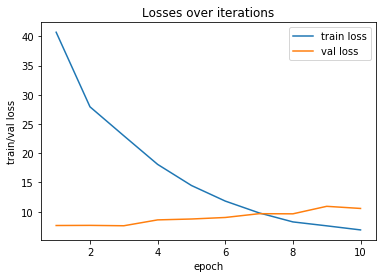

In [19]:
# Output = Adj_Sigmoid x Noun_Sigmoid
cross_anp_tagger_A = CrossTagger( len(adj_classes), len(noun_classes) )
cross_anp_tagger_A = train_crossmodel( cross_anp_tagger_A, 'cross-anp-tagger-A', trainXY, valXY, augment_imgs=False)

Consider ANP gold labels when training.


/home/gusliahs@GU.GU.SE/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 avg train loss 0.39322502837806455
Epoch 1 avg val loss   0.26571757514630595
Epoch 1 train+val time: 0:00:55 Total lapsed time: 0:00:55
Epoch 2 avg train loss 0.24764702786676218
Epoch 2 avg val loss   0.25972170791318345
Epoch 2 train+val time: 0:00:56 Total lapsed time: 0:01:52
Epoch 3 avg train loss 0.20715919332426103
Epoch 3 avg val loss   0.28441625208623955
Epoch 3 train+val time: 0:00:55 Total lapsed time: 0:02:47
Epoch 4 avg train loss 0.17172930279716117
Epoch 4 avg val loss   0.30404666739125415
Epoch 4 train+val time: 0:00:55 Total lapsed time: 0:03:43
Epoch 5 avg train loss 0.14869730070721907
Epoch 5 avg val loss   0.32236717401012345
Epoch 5 train+val time: 0:00:55 Total lapsed time: 0:04:39
Epoch 6 avg train loss 0.13137309485283055
Epoch 6 avg val loss   0.35461849551047054
Epoch 6 train+val time: 0:00:55 Total lapsed time: 0:05:35
Epoch 7 avg train loss 0.12039845858196743
Epoch 7 avg val loss   0.37387694178089024
Epoch 7 train+val time: 0:00:55 Total lapsed

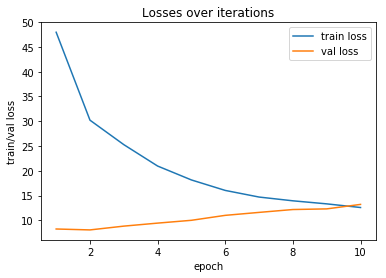

In [13]:
# Residue+ AN-reps-CrossMul
cross_anp_tagger_B = CrossTagger( len(adj_classes), len(noun_classes), fractorise_from="reps")
cross_anp_tagger_B = train_crossmodel(cross_anp_tagger_B, 'cross-anp-tagger-B', trainXY, valXY, augment_imgs=False,
                                      consider_anp_targets=True)

Consider ANP gold labels when training.


/home/gusliahs@GU.GU.SE/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 avg train loss 0.42240639495067914
Epoch 1 avg val loss   0.24997732379744135
Epoch 1 train+val time: 0:00:55 Total lapsed time: 0:00:55
Epoch 2 avg train loss 0.24081122740858893
Epoch 2 avg val loss   0.24394862642211299
Epoch 2 train+val time: 0:00:55 Total lapsed time: 0:01:50
Epoch 3 avg train loss 0.19539659067255552
Epoch 3 avg val loss   0.25022661061056237
Epoch 3 train+val time: 0:00:55 Total lapsed time: 0:02:45
Epoch 4 avg train loss 0.15734759260152206
Epoch 4 avg val loss   0.26277069699379707
Epoch 4 train+val time: 0:00:55 Total lapsed time: 0:03:41
Epoch 5 avg train loss 0.12693861352859953
Epoch 5 avg val loss   0.28561410067542916
Epoch 5 train+val time: 0:00:55 Total lapsed time: 0:04:36
Epoch 6 avg train loss 0.10283880821261251
Epoch 6 avg val loss   0.30072553167420046
Epoch 6 train+val time: 0:00:55 Total lapsed time: 0:05:32
Epoch 7 avg train loss 0.08520752728962508
Epoch 7 avg val loss   0.30412348576130405
Epoch 7 train+val time: 0:00:55 Total lapsed

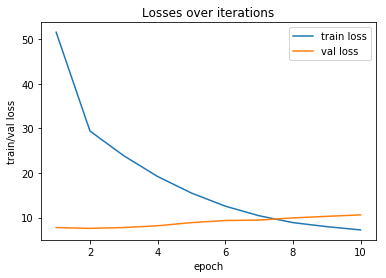

In [13]:
# Residue+ AN-Sigmoids-CrossMul
cross_anp_tagger_C = CrossTagger( len(adj_classes), len(noun_classes), fractorise_from="sigmoids"  )
cross_anp_tagger_C = train_crossmodel(cross_anp_tagger_C, 'cross-anp-tagger-C', trainXY, valXY, augment_imgs=False,
                                      consider_anp_targets=True )

### Load previously trained-and-saved models

In [9]:
anp_tagger = torch.load('trained-models/anp-tagger.pt')
adj_tagger = torch.load('trained-models/adj-tagger.pt')
noun_tagger = torch.load('trained-models/noun-tagger.pt')

In [10]:
cross_anp_tagger_A = torch.load('trained-models/cross-anp-tagger-A.pt')
cross_anp_tagger_B = torch.load('trained-models/cross-anp-tagger-B.pt')
cross_anp_tagger_C = torch.load('trained-models/cross-anp-tagger-C.pt')

### See how models perform by inputting image and print the predicted labels

In [11]:
def visualise_pred(img_fn, model_classes_dict, dataset=fn_ANPs,
                   img_path=flickr8K_imgs, threshold=0.1):
    '''Use an image as input and compare the original tagging vs the model-predicted tagging'''
    
    #---------------------------------
    if img_fn in dataset:
        gold_labels = dataset[img_fn]
    else:
        gold_labels = None
        
    print(f"Gold labels:", gold_labels)
    #---------------------------------
    
    test_bat = file_to_tensor(img_path+img_fn).unsqueeze(0) # turn to a batchsize=1 tensor
    
    #---------------------------------
    for model, classes in model_classes_dict.items():
        model.eval()
        with torch.no_grad():
            test_bat = test_bat.to(device)
            out = model(test_bat)
            if len(out)>1: # cross_out, (a_out, n_out)
                out = out[0] 

        out=(out>threshold).float()
        predicted_indices = (out[0]==1.0).nonzero(as_tuple=True)[0] # indices of values that are 1
        predicted_labels = [classes[i] for i in predicted_indices]
        
        print(f"Predicted:", predicted_labels)
        print()
        
    #---------------------------------
    with Image.open(img_path+img_fn) as pic:
        plt.axis('off') # hide the axes on the sides
        plt.imshow(pic)
    
    

Gold labels: [('brown', 'dog'), ('large', 'dog'), ('pink', 'jacket')]
Predicted: [('black', 'dog'), ('white', 'dog'), ('brown', 'dog'), ('grassy', 'field')]



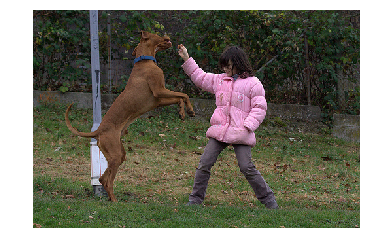

In [20]:
visualise_pred('2229509318_be3fef006b.jpg', {anp_tagger:ANP_classes}, threshold=0.03)

Gold labels: [('brown', 'dog'), ('large', 'dog'), ('pink', 'jacket')]
Predicted: ['pink', 'little', 'brown', 'grassy']

Gold labels: [('brown', 'dog'), ('large', 'dog'), ('pink', 'jacket')]
Predicted: ['girl', 'dog']



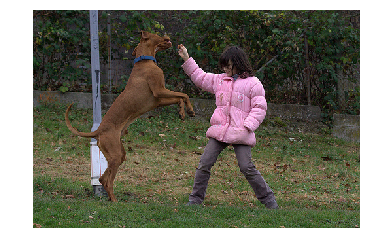

In [13]:
visualise_pred('2229509318_be3fef006b.jpg', {adj_tagger:adj_classes})
visualise_pred('2229509318_be3fef006b.jpg', {noun_tagger:noun_classes})

Gold labels: [('brown', 'dog'), ('large', 'dog'), ('pink', 'jacket')]
Predicted: [('pink', 'girl'), ('pink', 'dog'), ('brown', 'girl'), ('brown', 'dog')]



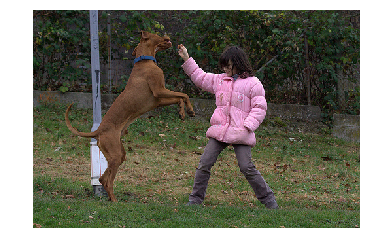

In [21]:
visualise_pred('2229509318_be3fef006b.jpg', {cross_anp_tagger_A:ANP_classes}, threshold=0.1)

Gold labels: [('brown', 'dog'), ('large', 'dog'), ('pink', 'jacket')]
Predicted: [('little', 'girl'), ('brown', 'dog')]

Gold labels: [('brown', 'dog'), ('large', 'dog'), ('pink', 'jacket')]
Predicted: [('brown', 'dog'), ('brown', 'shirt'), ('large', 'dog'), ('large', 'rock')]



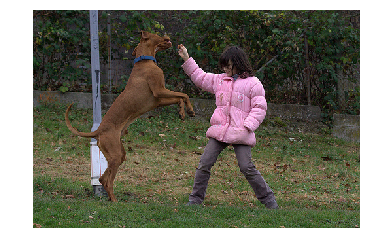

In [24]:
visualise_pred('2229509318_be3fef006b.jpg', {cross_anp_tagger_B:ANP_classes}, threshold=0.01) # res + reps
visualise_pred('2229509318_be3fef006b.jpg', {cross_anp_tagger_C:ANP_classes}, threshold=0.05) # res + sigs

2058472558_7dd5014abd.jpg
Gold labels: [('little', 'girl')]
Predicted: [('little', 'girl'), ('young', 'girl'), ('young', 'boy')]



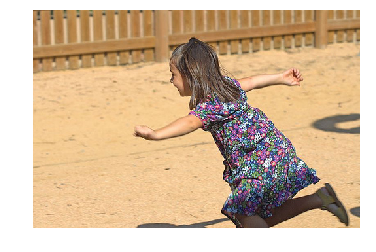

In [26]:
fn, _ = random.choice(val_fn_anp)
# '2229509318_be3fef006b.jpg'
# 3174196837_800689a2f3.jpg
# 241347547_902725b9f8.jpg
print(fn)
visualise_pred(fn, {anp_tagger:ANP_classes})

Gold labels: [('white', 'dog'), ('brown', 'dog')]
Predicted: [('black', 'dog'), ('white', 'dog'), ('brown', 'dog'), ('small', 'dog'), ('tan', 'dog')]

Predicted: ['white', 'brown']

Predicted: ['dog']

Predicted: [('white', 'dog'), ('brown', 'dog')]

Predicted: [('white', 'dog')]

Predicted: [('white', 'dog'), ('brown', 'dog')]



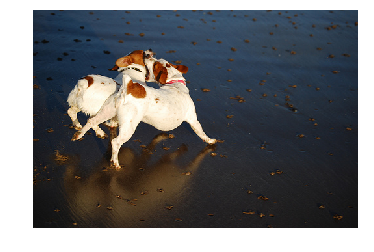

In [27]:
fn, _ = random.choice(val_fn_anp)
models_and_classes = {anp_tagger:ANP_classes,
                      adj_tagger:adj_classes,
                      noun_tagger:noun_classes, 
                      cross_anp_tagger_A:ANP_classes, 
                      cross_anp_tagger_B:ANP_classes, 
                      cross_anp_tagger_C:ANP_classes, 
                     }

visualise_pred(fn, models_and_classes)


Gold labels: None
Predicted: [('black', 'dog'), ('white', 'dog'), ('brown', 'dog')]

Predicted: ['pink', 'little', 'white', 'young', 'purple']

Predicted: ['dog']

Predicted: [('pink', 'dress'), ('pink', 'girl'), ('pink', 'dog'), ('pink', 'hat'), ('pink', 'shirt'), ('purple', 'girl'), ('purple', 'shirt')]

Predicted: [('little', 'girl'), ('young', 'girl')]

Predicted: [('pink', 'shirt'), ('little', 'girl'), ('young', 'girl')]



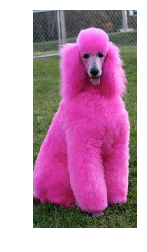

In [31]:
fn = 'pinkdog1.jpg'
visualise_pred(fn, models_and_classes, img_path='', threshold=0.08)

Gold labels: None
Predicted: [('little', 'girl'), ('young', 'girl'), ('young', 'boy')]

Predicted: ['pink', 'little', 'young']

Predicted: ['dog']

Predicted: [('pink', 'dress'), ('pink', 'girl'), ('pink', 'shirt'), ('little', 'dress'), ('little', 'girl'), ('little', 'shirt'), ('young', 'girl'), ('young', 'shirt'), ('red', 'girl'), ('red', 'shirt'), ('purple', 'girl')]

Predicted: [('little', 'girl'), ('young', 'girl')]

Predicted: [('little', 'girl'), ('young', 'girl')]



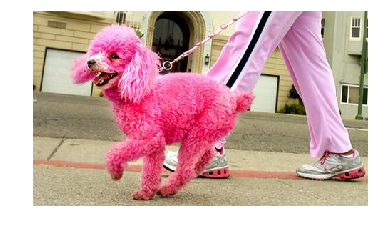

In [38]:
# fn = 'green-dogs.jpg'

fn = 'pinkdog2.jpg'
visualise_pred(fn, models_and_classes, img_path='', threshold=0.15)


In [14]:
# adj_tagger -> A labels
# noun_tagger -> N labels
# generate AxN labels for ANP [1,0,1,...]
# --> use as 

In [39]:
adj_classes

['pink',
 'wooden',
 'little',
 'black',
 'white',
 'brown',
 'small',
 'young',
 'orange',
 'red',
 'grassy',
 'green',
 'blue',
 'several',
 'yellow',
 'large',
 'tan',
 'snowy',
 'blonde',
 'rocky',
 'purple',
 'colorful',
 'other',
 'old',
 'asian',
 'haired']

In [40]:
noun_classes

['child',
 'dress',
 'girl',
 'building',
 'dog',
 'road',
 'street',
 'front',
 'hand',
 'grass',
 'man',
 'bench',
 'park',
 'ground',
 'hat',
 'glass',
 'rope',
 'fence',
 'beach',
 'ball',
 'water',
 'head',
 'side',
 'boy',
 'wall',
 'city',
 'shirt',
 'jean',
 'rock',
 'tree',
 'collar',
 'snow',
 'field',
 'picture',
 'person',
 'group',
 'people',
 'face',
 'car',
 'mouth',
 'toy',
 'air',
 'midair',
 'woman',
 'lake',
 'swimming',
 'couple',
 'baby',
 'body',
 'sand',
 'jacket',
 'pant',
 'stick',
 'kid',
 'hill',
 'camera',
 'top',
 'boat',
 'crowd',
 'guy',
 'jump',
 'skateboard',
 'trick',
 'skateboarder',
 'river',
 'ocean',
 'hair',
 'arm',
 'area',
 'background',
 'pool',
 'short',
 'mountain',
 'yard',
 'tennis',
 'helmet',
 'bike',
 'dirt',
 'bicycle',
 'race',
 'ramp',
 'toddler',
 'lady',
 'sidewalk',
 'outfit',
 'wood',
 'path',
 'coat',
 'suit',
 'rider',
 'soccer',
 'wave',
 'game',
 'team',
 'uniform',
 'swing',
 'adult',
 'sunglass',
 'player',
 'football',
 'tr